In [1]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import norm

In [107]:
from typing import Dict

In [2]:
print(sys.version)
plt.style.use("seaborn-dark")

3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


In [3]:
df_wti_raw = pd.read_csv(
    "../data/fred/DCOILWTICO.csv",
    index_col=0,
    header=0,
    parse_dates=["DATE"],
    date_parser=lambda d: datetime.strptime(d, "%Y-%m-%d")
)
df_cpi_raw = pd.read_csv(
    "../data/fred/CPIAUCSL.csv",
    index_col=0,
    header=0,
    parse_dates=["DATE"],
    date_parser=lambda d: datetime.strptime(d, "%Y-%m-%d")
)

In [4]:
start = datetime(2000, 1, 1)
end = datetime(2019, 9, 30)
def select_range(df):
    return df[np.logical_and(
        df.index >= start, df.index <= end
    )]
df_wti, df_cpi = map(select_range, (df_wti_raw, df_cpi_raw))
df_wti = df_wti[df_wti.values != "."]
df_wti, df_cpi = map(lambda x: x.astype(np.float32), (df_wti, df_cpi))

In [5]:
print(df_wti.info())
print(df_wti.head())
print(df_wti.tail())
print(df_cpi.info())
print(df_cpi.head())
print(df_cpi.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4956 entries, 2000-01-04 to 2019-09-30
Data columns (total 1 columns):
DCOILWTICO    4956 non-null float32
dtypes: float32(1)
memory usage: 58.1 KB
None
            DCOILWTICO
DATE                  
2000-01-04   25.559999
2000-01-05   24.650000
2000-01-06   24.790001
2000-01-07   24.790001
2000-01-10   24.709999
            DCOILWTICO
DATE                  
2019-09-24   57.220001
2019-09-25   56.380001
2019-09-26   56.240002
2019-09-27   55.950001
2019-09-30   54.090000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 237 entries, 2000-01-01 to 2019-09-01
Data columns (total 1 columns):
CPIAUCSL    237 non-null float32
dtypes: float32(1)
memory usage: 2.8 KB
None
              CPIAUCSL
DATE                  
2000-01-01  169.300003
2000-02-01  170.000000
2000-03-01  171.000000
2000-04-01  170.899994
2000-05-01  171.199997
              CPIAUCSL
DATE                  
2019-05-01  255.154999
2019-06-01  255.304993
2019-07-01  256.16

In [6]:
# Normalizing using CPIAUCSL to construct real crude oil price.
# Creating CPI referencing series
df_norm_cpi = df_cpi / df_cpi.iloc[0, 0]  # 2000.01.01 as 1.00 index.
df_norm_cpi_daily = df_norm_cpi.resample("d", fill_method="ffill", label="left")
# fig = plt.figure(figsize=(15, 3), dpi=300)
# plt.scatter(df_norm_cpi.index, df_norm_cpi.values, label="monthly", alpha=0.7, s=1, color="red")
# plt.plot(df_norm_cpi_daily, label="daily", alpha=0.3)
# plt.legend()
# plt.show()
df_norm_cpi = df_norm_cpi_daily

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()
  after removing the cwd from sys.path.


In [7]:
# Normalize operation, sequential implementation.
df_wti_real = pd.DataFrame(columns=["DCOILWTICO_REAL"], index=df_wti.index).astype(np.float32)
for t in df_wti_real.index:
    try:
        real_price = df_wti["DCOILWTICO"][t] / df_norm_cpi["CPIAUCSL"][t]
        df_wti_real["DCOILWTICO_REAL"][t] = real_price
    except KeyError:
        print(f"Skipped: {t}")

Skipped: 2019-09-03 00:00:00
Skipped: 2019-09-04 00:00:00
Skipped: 2019-09-05 00:00:00
Skipped: 2019-09-06 00:00:00
Skipped: 2019-09-09 00:00:00
Skipped: 2019-09-10 00:00:00
Skipped: 2019-09-11 00:00:00
Skipped: 2019-09-12 00:00:00
Skipped: 2019-09-13 00:00:00
Skipped: 2019-09-16 00:00:00
Skipped: 2019-09-17 00:00:00
Skipped: 2019-09-18 00:00:00
Skipped: 2019-09-19 00:00:00
Skipped: 2019-09-20 00:00:00
Skipped: 2019-09-23 00:00:00
Skipped: 2019-09-24 00:00:00
Skipped: 2019-09-25 00:00:00
Skipped: 2019-09-26 00:00:00
Skipped: 2019-09-27 00:00:00
Skipped: 2019-09-30 00:00:00


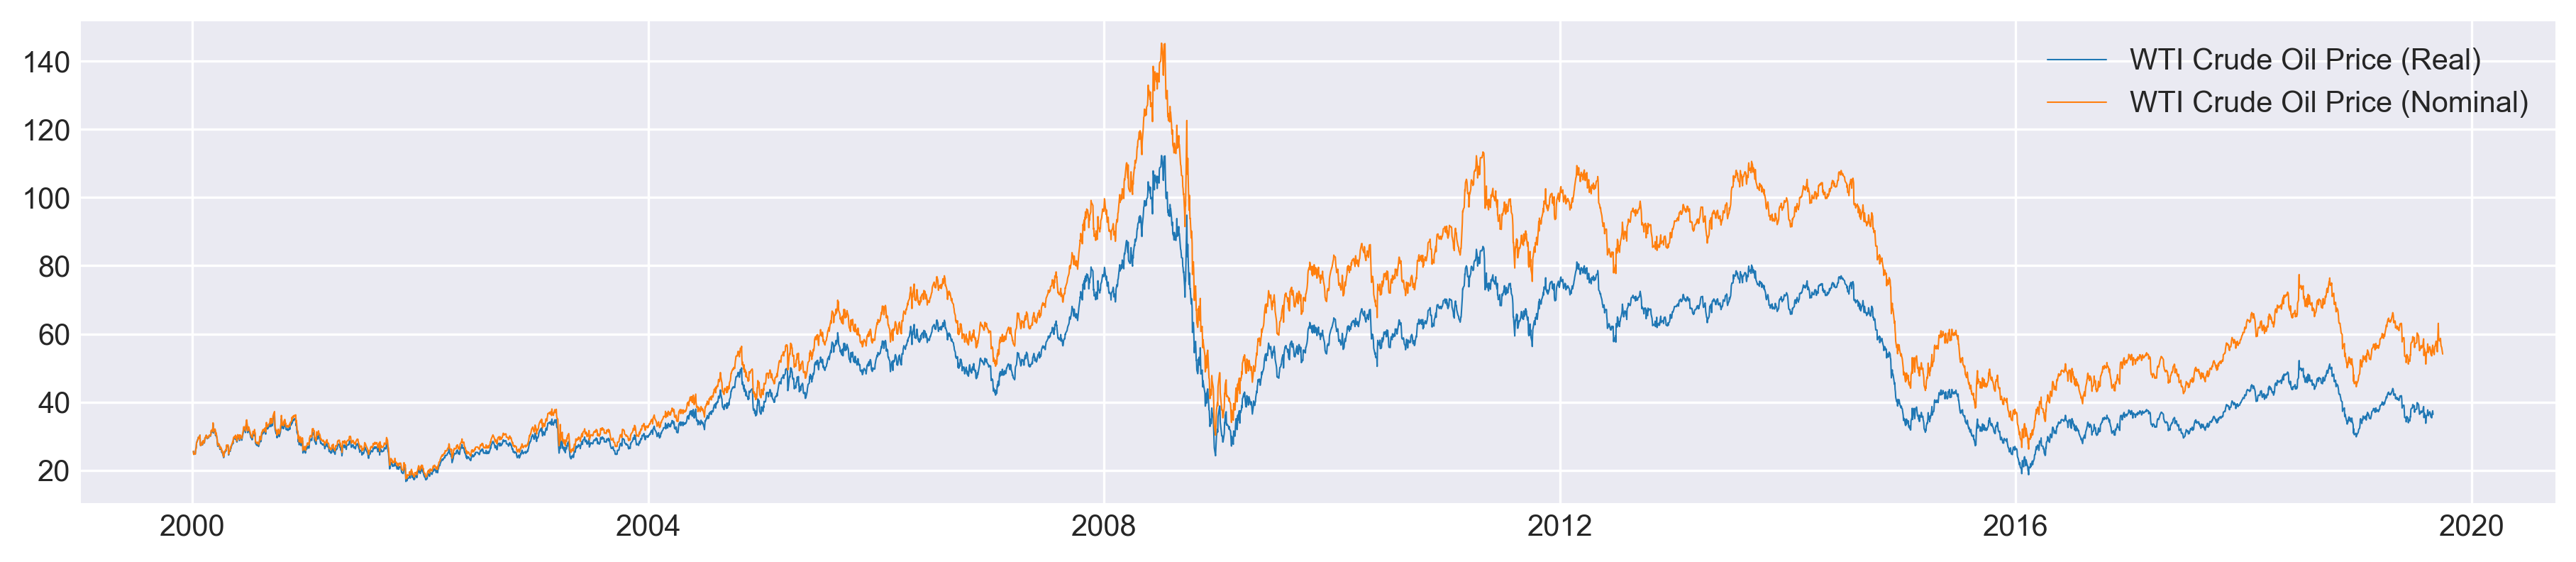

In [8]:
plt.rcParams["figure.figsize"] = (15, 3)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.grid"] = True
plt.plot(df_wti_real, linewidth=0.5, label="WTI Crude Oil Price (Real)")
plt.plot(df_wti, linewidth=0.5, label="WTI Crude Oil Price (Nominal)")
plt.legend()
plt.show()

In [9]:
# Transform to log-difference (return)
def construct_return(raw_price: pd.DataFrame):
    log_price = np.log(raw_price).dropna()
    return log_price.diff().dropna()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


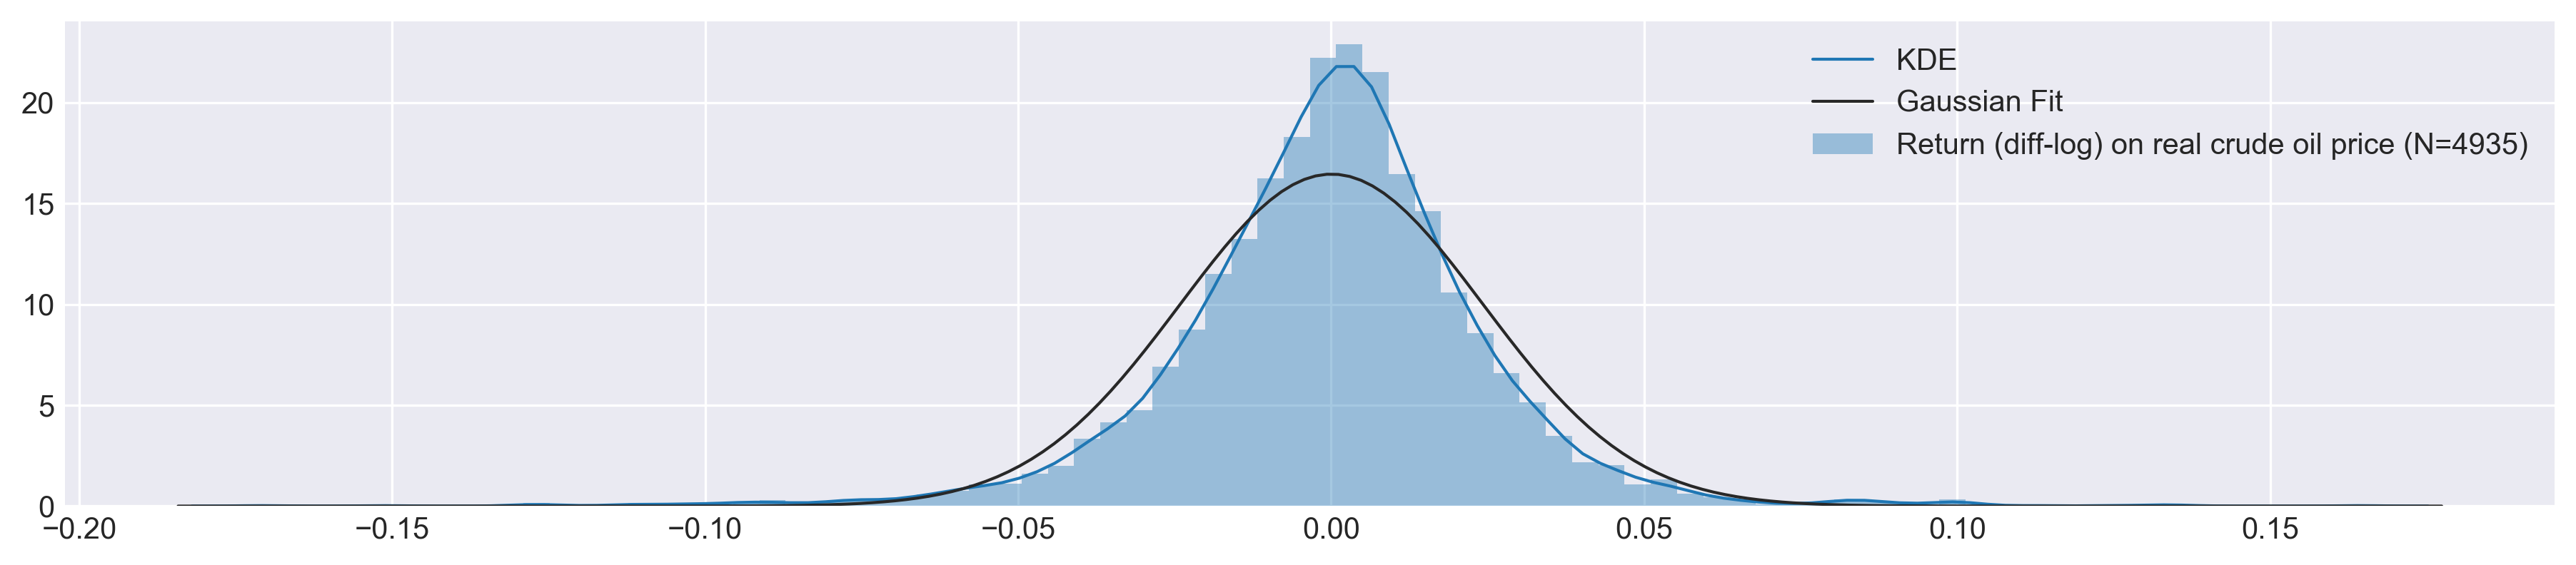

In [10]:
df_wti_return = construct_return(df_wti_real)
sns.distplot(
    df_wti_return.values,
    bins=80,
    fit=norm,
    fit_kws={"lw": 1, "label": "Gaussian Fit"},
    kde=True,
    kde_kws={"lw": 1, "label": "KDE"},
    label=f"Return (diff-log) on real crude oil price (N={len(df_wti_return.values)})")
plt.legend()
plt.show()

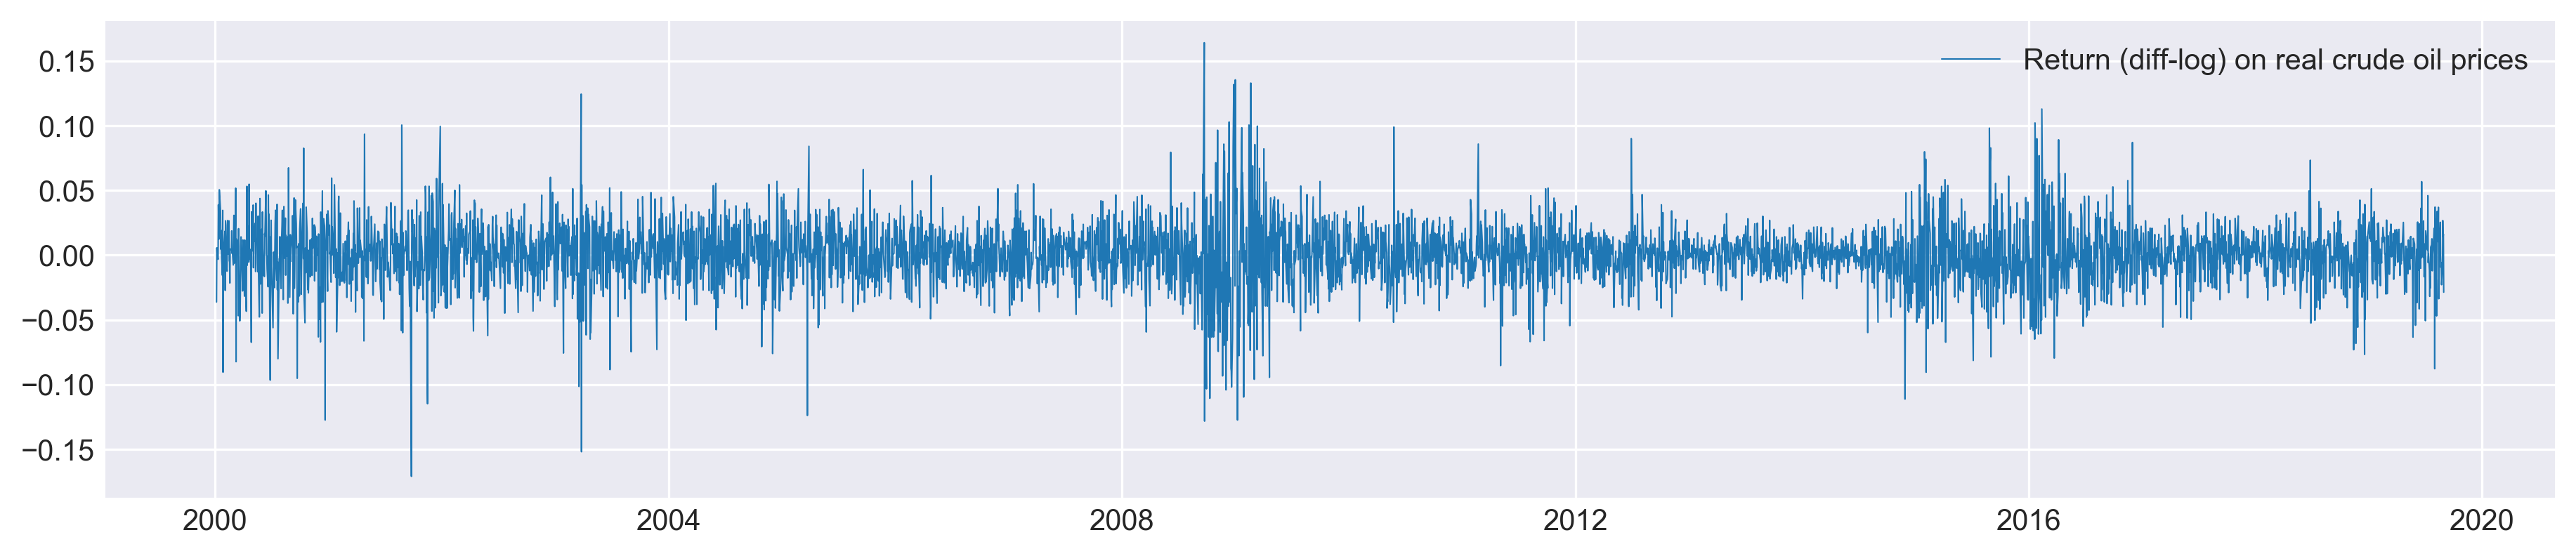

In [11]:
plt.plot(df_wti_return, linewidth=0.5, label="Return (diff-log) on real crude oil prices")
plt.legend()
plt.show()

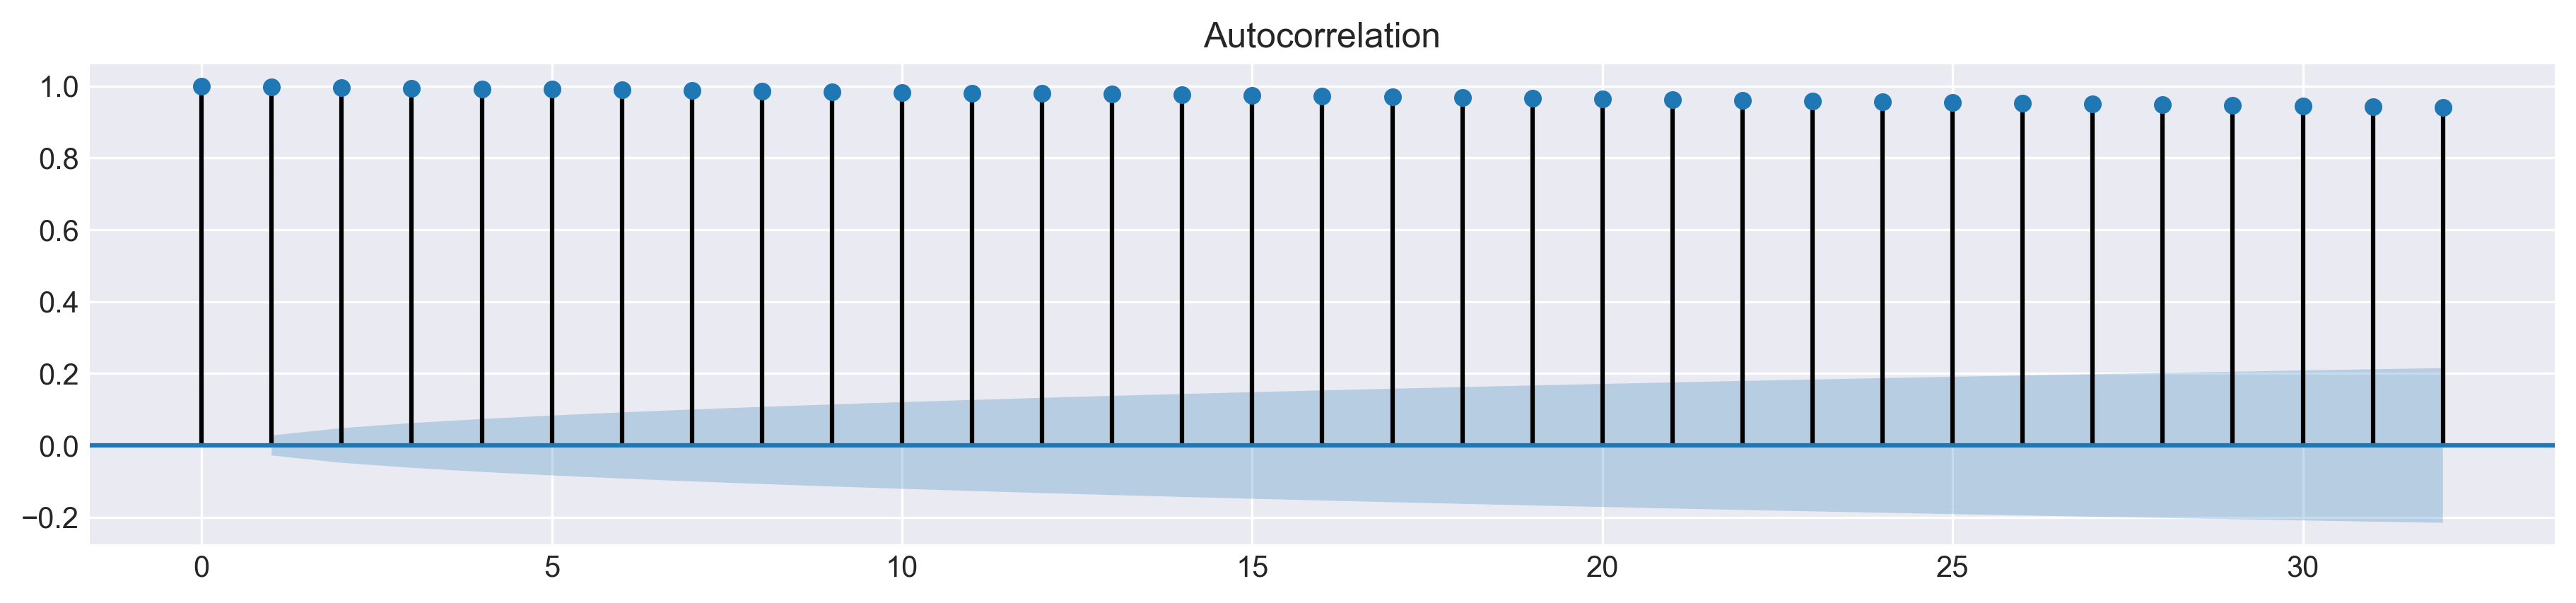

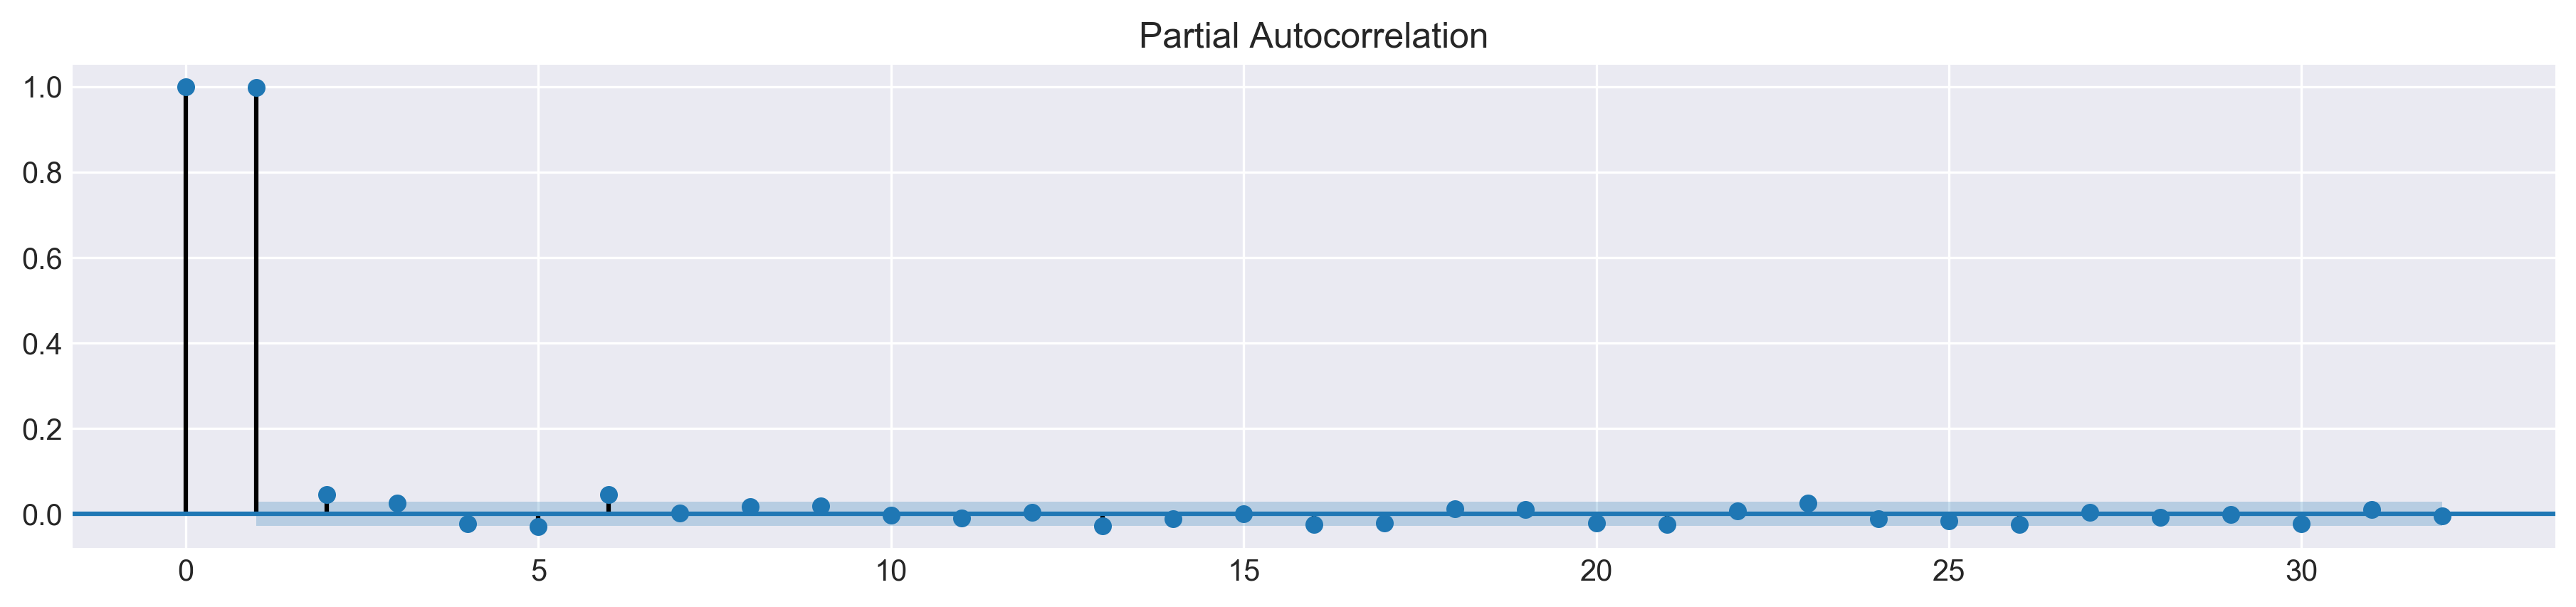

In [12]:
# For real prices.
sm.tsa.graphics.plot_acf(df_wti_real.dropna().values, lags=32)
plt.show()
sm.tsa.graphics.plot_pacf(df_wti_real.dropna(), lags=32)
plt.show()

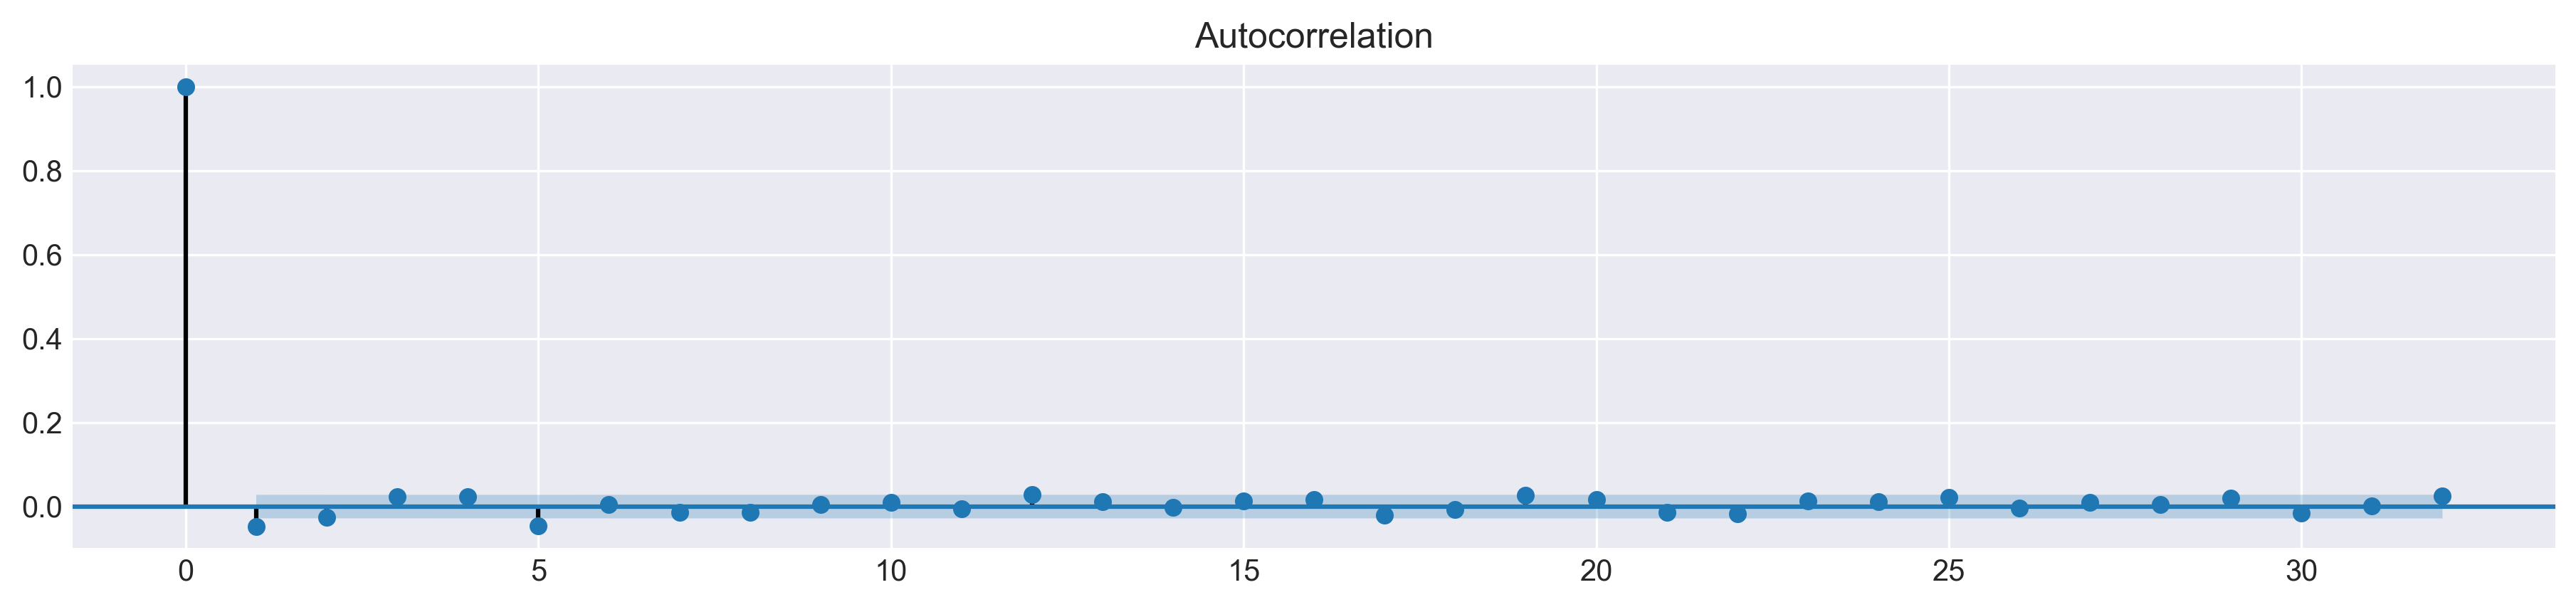

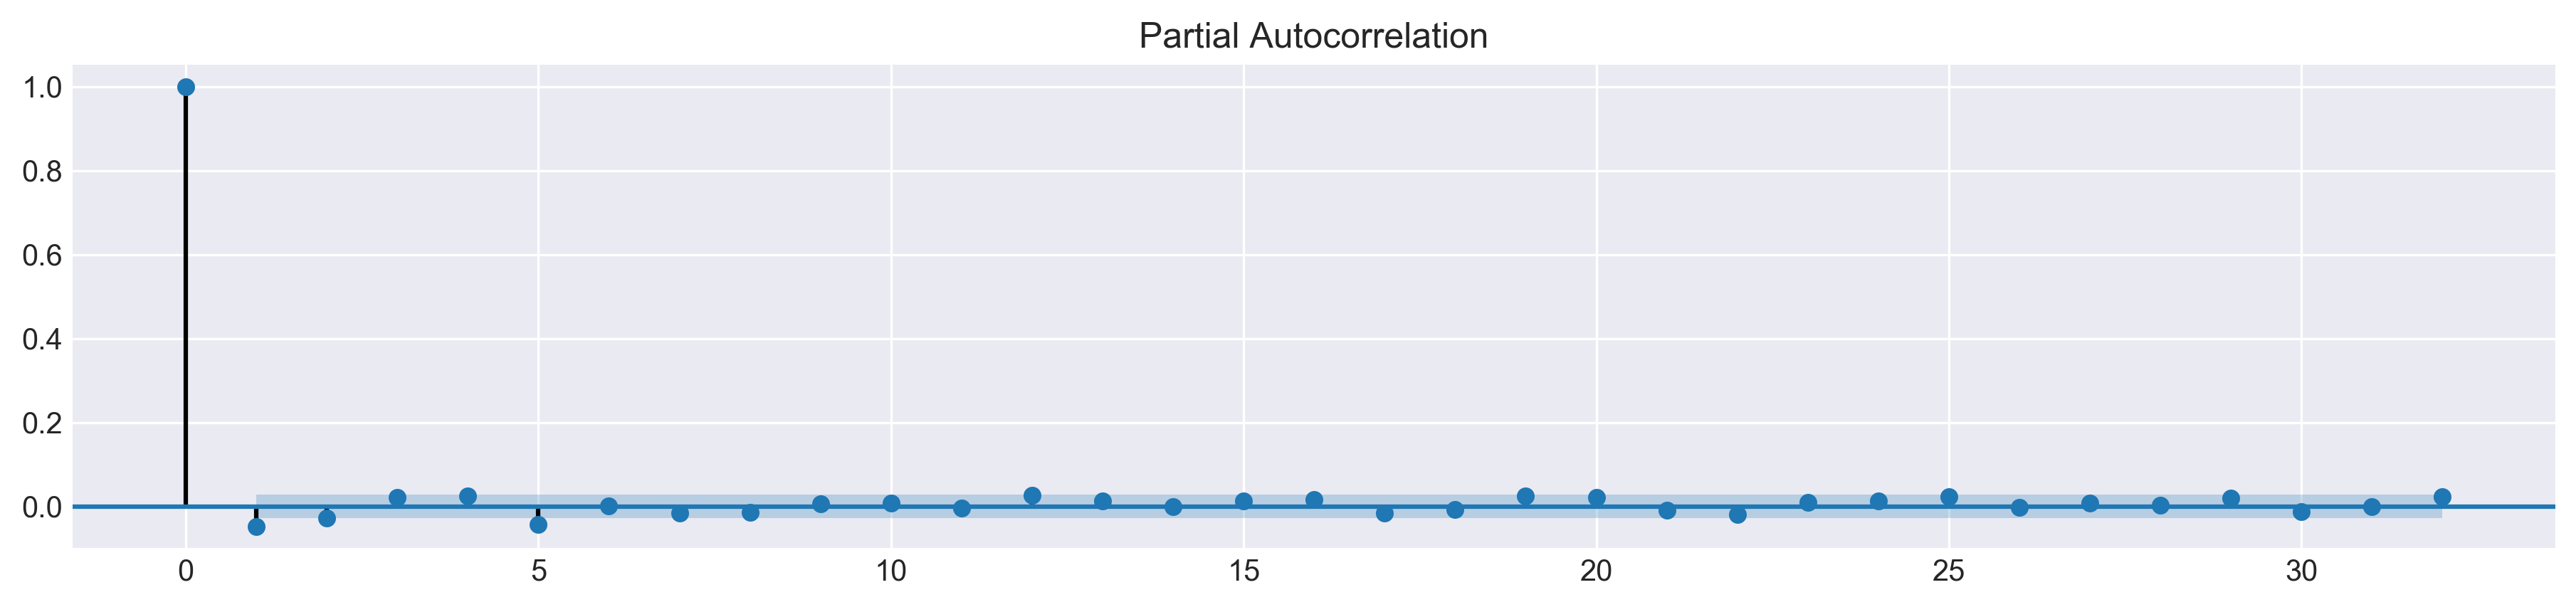

In [13]:
# For change on real prices.
sm.tsa.graphics.plot_acf(df_wti_real.diff().dropna().values, lags=32)
plt.show()
sm.tsa.graphics.plot_pacf(df_wti_real.diff().dropna(), lags=32)
plt.show()

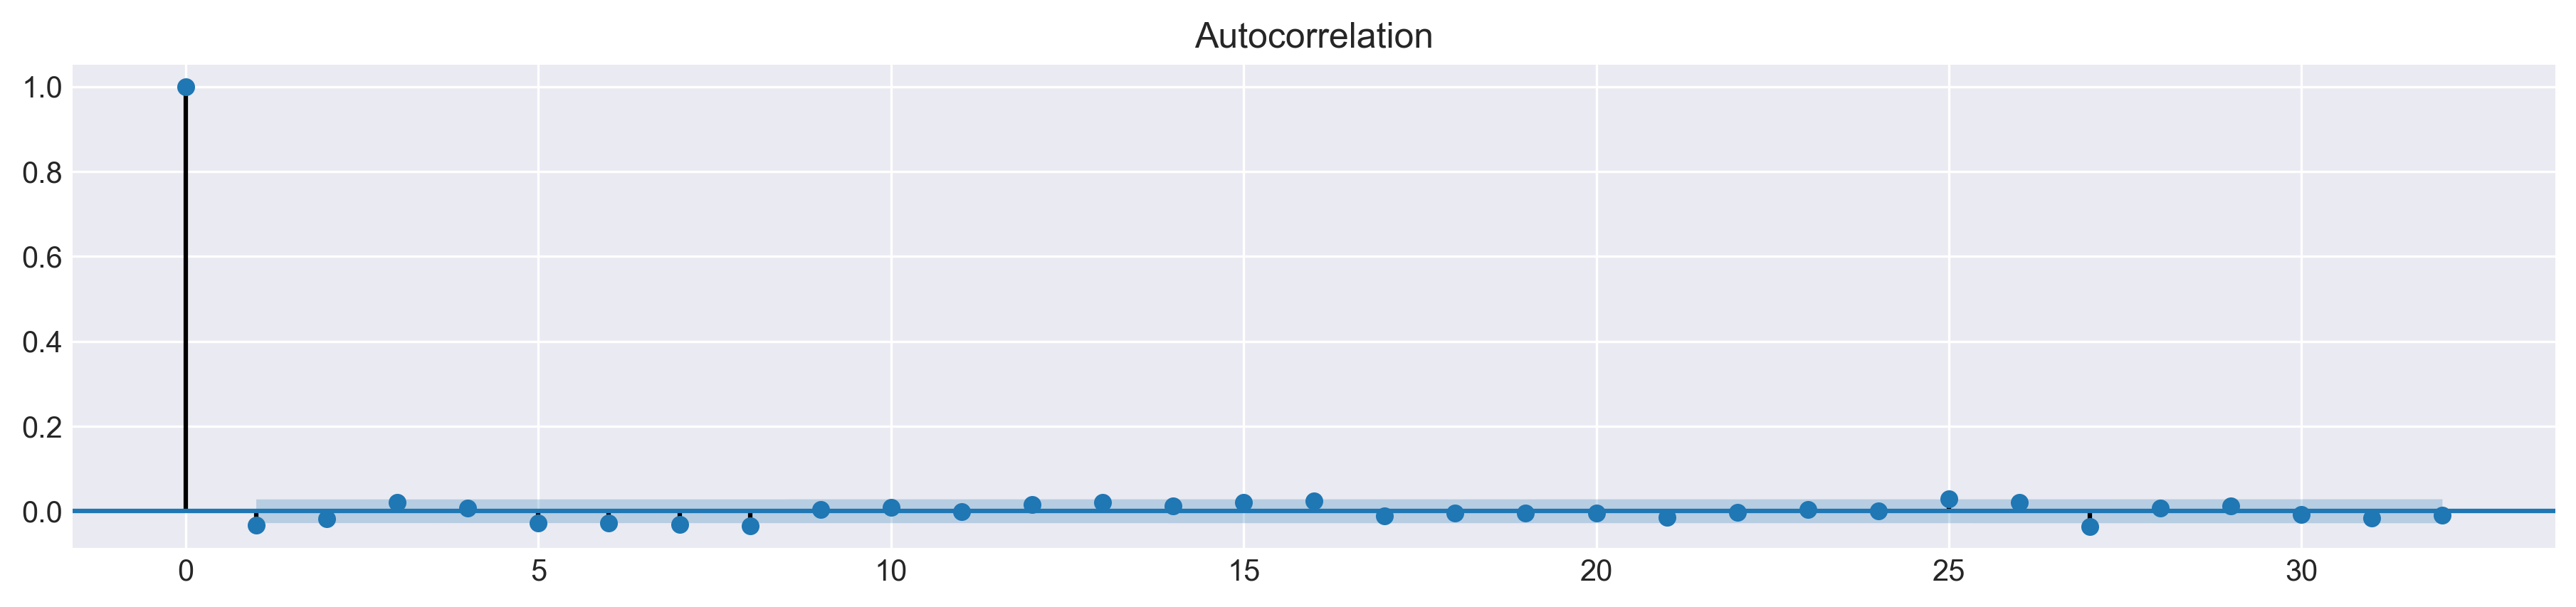

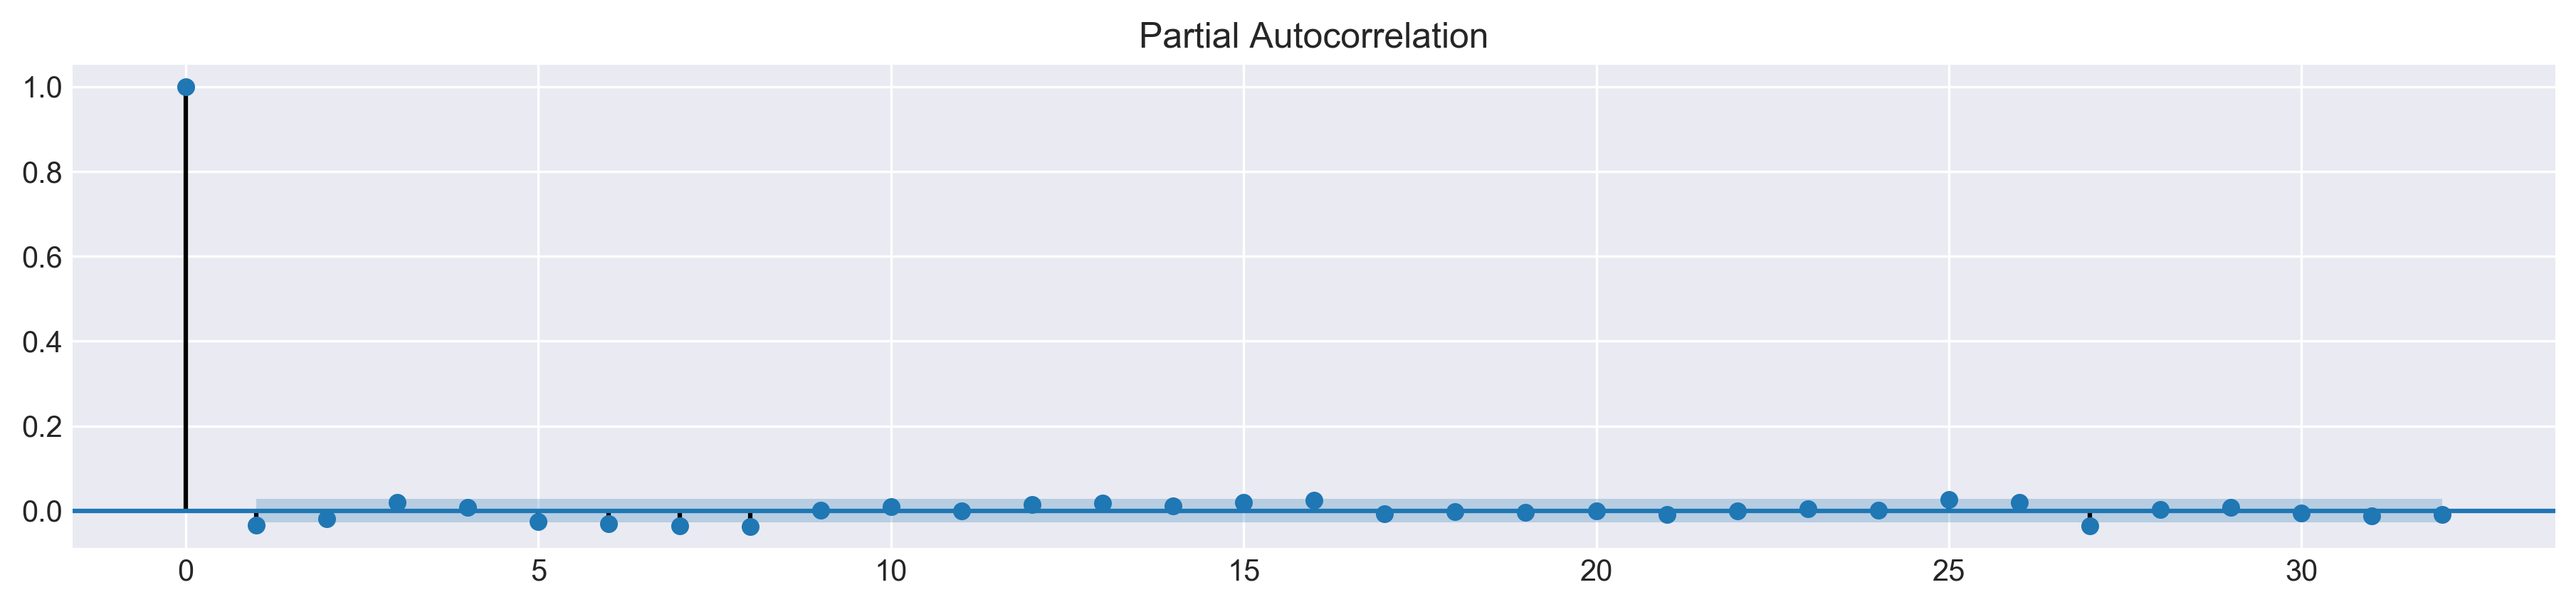

In [14]:
# For returns on real prices.
sm.tsa.graphics.plot_acf(df_wti_return.dropna().values, lags=32)
plt.show()
sm.tsa.graphics.plot_pacf(df_wti_return.dropna(), lags=32)
plt.show()

In [15]:
# Save generated results
df_wti_real.dropna().to_csv("../data/ready_to_use/wti_crude_oil_price_real.csv")
df_wti_return.dropna().to_csv("../data/ready_to_use/wti_crude_oil_return_real.csv")

In [232]:
def series_summary(
    series: pd.DataFrame
) -> pd.DataFrame:
    """
    Constructs features for a subsequence in the original series.
    """
    collection = pd.DataFrame()
    collection["mean"] = np.mean(series).values
    collection["std"] = np.std(series).values

    # Use acf and pacf to characterize the dynamics of series
    acf_lags, pacf_lags = 2, 2
    acf = pd.DataFrame(
        sm.tsa.stattools.acf(series, nlags=acf_lags)[1:].reshape(1, -1),
        columns=[f"acf_lag_{i}" for i in range(1, acf_lags + 1)]
    )
    pacf = pd.DataFrame(
        sm.tsa.stattools.pacf(series, nlags=pacf_lags)[1:].reshape(1, -1),
        columns=[f"pacf_lag_{i}" for i in range(1, pacf_lags + 1)]
    )
    collection = pd.concat([collection, acf, pacf], axis=1)
    return collection

In [256]:
# Month-based clustering, to create regimes.
# df_wti_real.groupby([(DF.index.year),(DF.index.month)]).sum()
def monthly_subsequence(
    df: pd.DataFrame,
    statistic: callable = series_summary
) -> (Dict[str, pd.DataFrame], pd.DataFrame):
    """
    Groups the entire series to monthly sub-series.
    Creates features describing the monthly subsequence, which can be used for time series clustering.
    """
    yr_range = sorted(set(df.index.year))
    mo_range = sorted(set(df.index.month))
    subsequences = dict()
    stats = list()
    for yr in yr_range:
        for mo in mo_range:
            mask = np.logical_and(df.index.year == yr, df.index.month == mo)
            str_mo = "0" + str(mo) if len(str(mo)) == 1 else str(mo)
            time = str(yr) + "-" + str_mo
            subseq = df[mask]
            if len(subseq) > 0:
                subsequences[time] = subseq
                # Summary statistic
                stats_month = statistic(subseq)
                stats_month["Date"] = [time]
                stats.append(stats_month)
    stats_all = pd.concat(stats, axis=0)
#     stats_all.reset_index(inplace=True, drop=True)
    stats_all.index = pd.to_datetime(stats_all["Date"], format="%Y-%m")
    stats_all.drop(columns=["Date"], inplace=True)
    return (subsequences, stats_all)

In [257]:
mo_subseqs, mo_stats = monthly_subsequence(df_wti_return)

In [258]:
mo_stats

,mean,std,acf_lag_1,acf_lag_2,pacf_lag_1,pacf_lag_2
Date,,,,,,
2000-01-01,0.004367,0.031102,0.044891,0.152414,0.047531,0.169589
2000-02-01,0.004813,0.015707,-0.184753,-0.128547,-0.194477,-0.187752
2000-03-01,-0.005880,0.029634,-0.099840,-0.182034,-0.104378,-0.212582
2000-04-01,-0.002272,0.030475,0.043113,-0.152349,0.045509,-0.172701
2000-05-01,0.005441,0.024179,-0.133782,-0.186741,-0.140152,-0.229567
2000-06-01,0.004784,0.029803,0.028344,-0.060796,0.029694,-0.067817
2000-07-01,-0.008848,0.027950,0.090077,0.044157,0.095081,0.040679
2000-08-01,0.008045,0.023748,-0.085906,-0.480290,-0.089810,-0.538441
2000-09-01,-0.003732,0.033046,0.105903,0.078112,0.111476,0.075300


In [235]:
# standardlize
print(mo_stats.shape)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
mo_stats_normalized = scaler.fit_transform(mo_stats)

(236, 6)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [271]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(mo_stats_normalized)

In [293]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3)
gmm_labels = gmm.fit_predict(mo_stats_normalized)

In [338]:
plt.rcParams["figure.figsize"] = (9, 3)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.grid"] = True

In [350]:
# Cast monthly 
for t, val in zip(df_wti_return.index, ):

DCOILWTICO_REAL


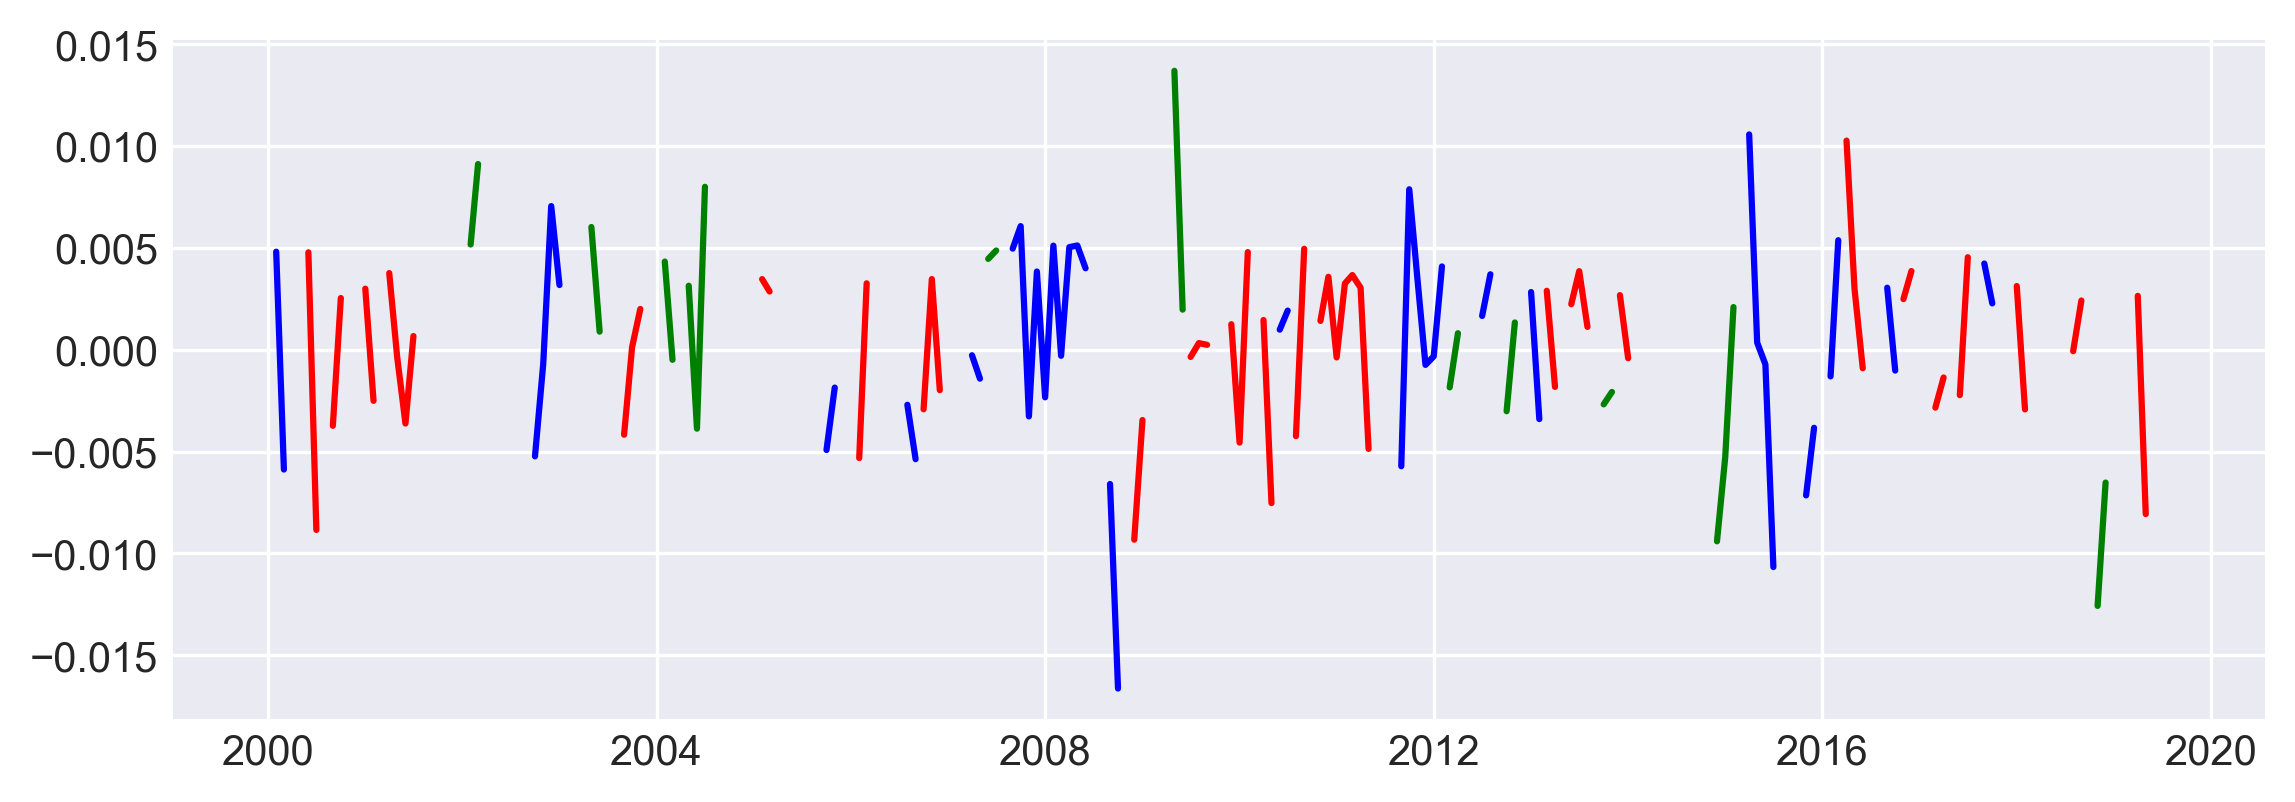

In [343]:
color_map = {0: "r", 1: "g", 2: "b"}

def plot_func(df: pd.DataFrame, labels: np.array, plot_col: str) -> None:
    assert len(df) == len(labels), "labels and dataframe should have the same length."
    for current_label in set(labels):
        current_df = df.copy()
        # Replace other label as None, so not plotted.
        mask = (labels == current_label)
        current_df[np.logical_not(mask)] = None
        plt.plot(current_df[plot_col], color=color_map[current_label])

plot_func(mo_stats, gmm_labels, "mean")

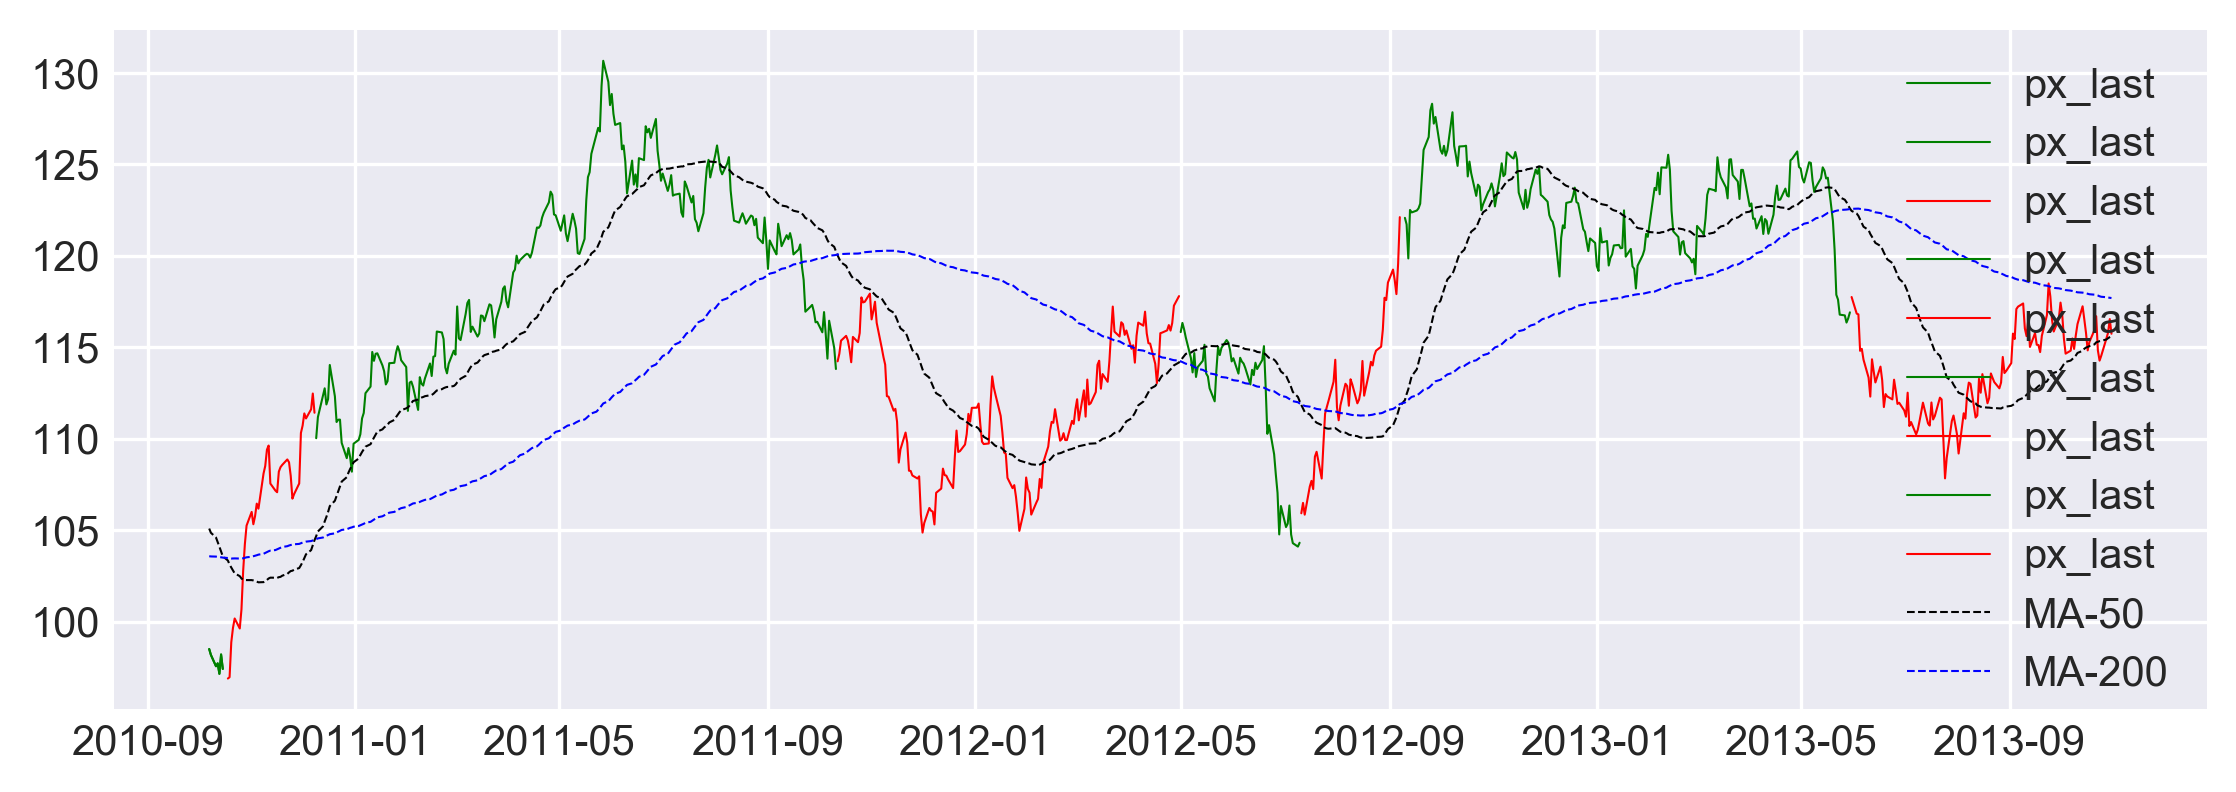

In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# simulate data
# =============================
np.random.seed(1234)
df = pd.DataFrame({'px_last': 100 + np.random.randn(1000).cumsum()}, index=pd.date_range('2010-01-01', periods=1000, freq='B'))
df['50dma'] = df['px_last'].rolling(window=50).mean()
df['200dma'] = df['px_last'].rolling(window=200).mean()
df['label'] = np.where(df['50dma'] > df['200dma'], 1, -1)


# plot
# =============================
df = df.dropna(axis=0, how='any')

fig, ax = plt.subplots()

def plot_func(group):
    global ax
    color = 'r' if (group['label'] < 0).all() else 'g'
    lw = 0.5
    ax.plot(group.index, group.px_last, c=color, linewidth=lw)

df.groupby((df['label'].shift() * df['label'] < 0).cumsum()).apply(plot_func)

# add ma lines
ax.plot(df.index, df['50dma'], 'k--', label='MA-50', linewidth=0.5)
ax.plot(df.index, df['200dma'], 'b--', label='MA-200', linewidth=0.5)
ax.legend(loc='best')

In [337]:
# simulate data
# =============================
np.random.seed(1234)
# df = pd.DataFrame({'px_last': 100 + np.random.randn(1000).cumsum()}, index=pd.date_range('2010-01-01', periods=1000, freq='B'))
df = pd.DataFrame(
    data={"monthly mean": mo_stats["mean"]},
    index=mo_stats.index
)
df['50dma'] = df['monthly mean'].rolling(window=50).mean()
df['200dma'] = df['monthly mean'].rolling(window=200).mean()
# df['label'] = np.where(df['50dma'] > df['200dma'], 1, -1)
df["label"] = gmm_labels


# plot
# =============================
# df = df.dropna(axis=0, how='any')

fig, ax = plt.subplots()

def plot_func(group):
    global ax
    print(set(group["label"]))
    color = 'r' if (group['label'] < 1).all() else 'g'
    lw = 0.5
    ax.plot(group.index, group["monthly mean"], c=color, linewidth=lw)

df.groupby((df['label'].shift() * df['label'] < 0).cumsum()).apply(plot_func)

# add ma lines
ax.plot(df.index, df['50dma'], 'k--', label='MA-50')
ax.plot(df.index, df['200dma'], 'b--', label='MA-200')
ax.legend(loc='best')

TypeError: 'RcParams' object is not callable